<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6
### <center> Beating benchmarks in "How good is your Medium article?"
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline".

In [67]:
import os
import json
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.

In [4]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    first = ''
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            published = json_data['published']['$date']
            title = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            author = str(json_data['author']['url'])
            feature_files[0].write(first + content_no_html_tags)
            feature_files[1].write(first + published)
            feature_files[2].write(first + title)
            feature_files[3].write(first + author)
            first = '\n'

In [5]:
PATH_TO_DATA = '../../../.kaggle/competitions/how-good-is-your-medium-article' # modify this if you need to

In [6]:
#extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

In [7]:
#extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [8]:
cv = CountVectorizer(max_features=100000)
X_train_content_sparse = cv.fit_transform(open(os.path.join(PATH_TO_DATA,
                                                                    'train_content.txt'), 'r', encoding='utf-8'))
X_test_content_sparse = cv.transform(open(os.path.join(PATH_TO_DATA,
                                                                    'test_content.txt'), 'r', encoding='utf-8'))

In [9]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 100000), (34645, 100000))

In [10]:
#tf_content = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
#X_train_content_sparse = tf_content.fit_transform(open(os.path.join(PATH_TO_DATA,
#                                                                    'train_content.txt'), 'r', encoding='utf-8'))
#X_test_content_sparse = tf_content.transform(open(os.path.join(PATH_TO_DATA,
#                                                                    'test_content.txt'), 'r', encoding='utf-8'))

In [11]:
tf_title = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)
X_train_title_sparse = tf_title.fit_transform(open(os.path.join(PATH_TO_DATA,
                                                                    'train_title.txt'), 'r', encoding='utf-8'))
X_test_title_sparse = tf_title.transform(open(os.path.join(PATH_TO_DATA,
                                                                    'test_title.txt'), 'r', encoding='utf-8'))

In [12]:
X_train_title_sparse, X_test_title_sparse

(<62313x100000 sparse matrix of type '<class 'numpy.float64'>'
 	with 795892 stored elements in Compressed Sparse Row format>,
 <34645x100000 sparse matrix of type '<class 'numpy.float64'>'
 	with 383283 stored elements in Compressed Sparse Row format>)

In [13]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'train_published.txt'), sep="\n", header=None, names=["data"])
test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'test_published.txt'), sep="\n", header=None, names=["data"])
train_split = train_df.shape[0]
df = pd.concat([train_df, test_df], axis = 0)

In [14]:
df['data'] = df['data'].apply(pd.to_datetime)

In [15]:
df['hour'] = df['data'].apply(lambda x: x.hour)

In [16]:
df['year'] = df['data'].apply(lambda x: x.year)

In [17]:
df['month'] = df['data'].apply(lambda x: x.month)

In [18]:
df['is_weekend'] = df['data'].apply(lambda x: x.weekday() in [5,6]).astype(int)

In [19]:
df['is_day'] = df['data'].apply(lambda x: 9<=x.hour<=18).astype(int)

In [20]:
df['is_night'] = df['data'].apply(lambda x: 0<=x.hour<=7).astype(int)

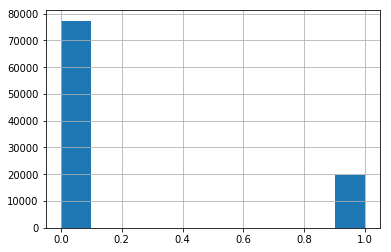

In [21]:
df['is_night'].hist();

In [22]:
features = ['hour', 'year', 'month']
X_train_time_features_sparse = df[:train_split][features]
X_test_time_features_sparse = df[train_split:][features]

In [23]:
#X_train_time_features_sparse['y'] = y_train

In [24]:
#plt.scatter(X_train_time_features_sparse['month'], X_train_time_features_sparse['y'])

In [25]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

((62313, 3), (34645, 3))

In [26]:
pd_train = pd.read_csv(os.path.join(PATH_TO_DATA,'train_author.txt'), sep="\n", header=None, names=["author"])
pd_test = pd.read_csv(os.path.join(PATH_TO_DATA,'test_author.txt'), sep="\n", header=None, names=["author"])

authors = pd.concat([pd_train, pd_test], axis = 0)

In [27]:
dict_authors = {author:i for i, author in enumerate(set(authors['author'].values))}

In [28]:
authors['index'] = authors['author'].apply(lambda x: dict_authors[x]).astype(int)

train_author = authors[:train_split]
test_author = authors[train_split:]

In [29]:
ohe = OneHotEncoder()
ohe.fit(authors['index'].values.reshape(-1, 1))
X_train_author_sparse = ohe.transform(train_author['index'].values.reshape(-1, 1))
X_test_author_sparse = ohe.transform(test_author['index'].values.reshape(-1, 1))

**Join all sparse matrices.**

In [30]:
X_train_sparse = csr_matrix(hstack([X_train_content_sparse, X_train_title_sparse,
                                    X_train_author_sparse, X_train_time_features_sparse]))

In [31]:
X_test_sparse = csr_matrix(hstack([X_test_content_sparse, X_test_title_sparse,
                                    X_test_author_sparse, X_test_time_features_sparse]))

**Read train target and split data for validation.**

In [32]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA,'train_log1p_recommends.csv'),
                           index_col='id')
y_train = train_target['log_recommends'].values

In [33]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [35]:
ridge = Ridge(random_state=17)

In [36]:
%%time
ridge.fit(X_train_part, y_train_part);

CPU times: user 5min 33s, sys: 492 ms, total: 5min 33s
Wall time: 5min 35s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [37]:
ridge_pred = ridge.predict(X_valid)

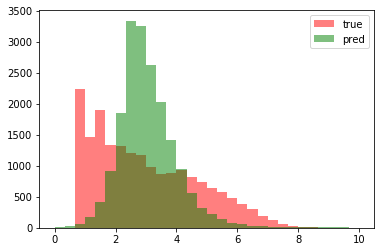

In [38]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [39]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.2864077554252242, 2.619760109055835)

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [40]:
%%time
ridge.fit(X_train_sparse, y_train);

CPU times: user 7min 58s, sys: 786 ms, total: 7min 58s
Wall time: 8min 2s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [41]:
%%time
ridge_test_pred = ridge.predict(X_test_sparse)

CPU times: user 55.1 ms, sys: 3.97 ms, total: 59 ms
Wall time: 59.1 ms


In [42]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA,'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [43]:
write_submission_file(ridge_test_pred, 'assignment6_medium_submission.csv')

In [57]:
np.mean(ridge_test_pred)

3.122592006408021

In [ ]:
sns.countplot(ridge_test_pred)

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [59]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      'medium_all_zeros_submission.csv')

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [60]:
#4.23328 - improve
#4 - worse
ridge_test_pred_modif = ridge_test_pred + (4.33328 - np.mean(ridge_test_pred))

In [61]:
write_submission_file(ridge_test_pred_modif, 
                      'assignment6_medium_submission_with_hack.csv')

In [62]:
np.mean(ridge_test_pred_modif)

4.33328